In [14]:
import os
import numpy as np
import sys

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [15]:
# given a directory and a list of the wanted classes, it parses all files
# in the directory that start with tracelog and extract the running times
# for the wanted classes
# the return structure is a list of lists, each list contains 4 elements
# [PErank, regeionName, inclusiveTime, exclusiveTime]
#
# returnes list is ordered by PE rank

def getAllTimes( directory, wantedClasses):
    
    if not os.path.exists(traceDir):
        print("Given directory" + traceDir + "does not exist.\nAborting...")
        exit(-1)
    
    allTimes = []
    
    #all files in the directory
    for traceFile in os.listdir(traceDir):
        if not traceFile.startswith("tracelog"):
            continue

        thisPE = traceFile.split('.')[2]
        #print(thisPE)
        #print(traceFile)

        with open( os.path.join(traceDir,traceFile) ) as f:
            #line = f.readline()
            for line in f:

                splittedLine = line.split()
                #print(splittedLine)
                if len( splittedLine )<2: #this line does not contain data to gather
                    continue

                region = splittedLine[1]  #the format that scai uses
                regionClass = region.split('.')[0]

                #print( region )
                #gather for some interesting classes, not all
                if not regionClass in interestClasses: 
                    continue

                inclusInd = splittedLine.index('inclusive')
                inclTime = splittedLine[inclusInd+2][:-1]  #last char is a comma
                exclTime = splittedLine[-1]

                allTimes.append( [thisPE, region, inclTime, exclTime] )

    allTimes.sort( key= lambda x: int(x[0]) )
    
    return allTimes

In [31]:
# allTimes as returned from getAllTimes
# wantedPEs, a list of numbers for the wanted PEs to plot
# wantedRegions, the names of the wanted regions to plot

def plotWantedPEsWantedRegions( allTimes, wantedPEs, wantedRegions , plotPerWhat="pe"):
    numWantedPEs = len(wantedPEs)
    numWantedRegions = len(wantedRegions)
    
    wantedTimes = []

    # t[0] is the PErank, t[1] is the region name
    for t in allTimes:
        if ( int(t[0]) in wantedPEs) and (t[1] in wantedRegions):
            wantedTimes.append(t)
    
    #timesPerPE = dict()
    
    timesPerPE = [ [] for i in range(numWantedPEs)]
    thisPE = -1
    #remember: in allTimes, data are sorted by PE rank. Also, the regions
    #appear in the same order
    for wt in wantedTimes:
        thisPE = int(wt[0]) #this does not work if wanted PEs is not all
        thisPEind = wantedPEs.index(thisPE)
        region = wt[1]
        inclTime = float(wt[2])
        timesPerPE[thisPEind].append( [region, inclTime] )
    
    assert( len(timesPerPE)==numWantedPEs )
    assert( len(timesPerPE[0])==numWantedRegions)
    
    missingFiles = 0 #count missing files
    
    # transpose in order to plot per region
    timePerRegion = { name:[] for name in wantedRegions}
    
    for wt in timesPerPE:
        # a file for some PE may be missing
        if len(wt)==0:
            missingFiles += 1
            continue
        assert( len(wt)==numWantedRegions )
        
        for j in range(numWantedRegions):
            region = wt[j][0]
            value =  wt[j][1]
            timePerRegion[region].append( value )
            
    #print( timePerRegion )
        
    numExistingPEs = numWantedPEs-missingFiles
    assert( len(timePerRegion)==numWantedRegions )
    assert( len(timePerRegion[wantedRegions[0]])==numExistingPEs )
    
    ##
    ## plot
    ##
    
    fig, ax = plt.subplots(figsize=(15,10))
    plt.rcParams.update({'font.size': 25})
    
    if plotPerWhat=="pe":        
        plt.title( "Times per PE for " + str(numWantedRegions)+ " regions." )

        for x in timePerRegion:
            plt.plot( timePerRegion[x] , label=x)

        plt.xticks( np.arange(0, numPEs, 1), wantedPEs, rotation=0, fontsize=16 )
        
    elif plotPerWhat=="region":
        plt.title( "Times per region for " +str(numWantedPEs)+" PEs"  )

        for i in range(numWantedPEs):
            plt.plot( [float(x[1]) for x in timesPerPE[i]] , label=wantedPEs[i])

        xticks = [ x[0] for x in timesPerPE[0]] #wantedRegions
        plt.xticks( np.arange(0, len(xticks), 1), xticks, rotation=90, fontsize=16 )
    else:
        print("Wrong value for parameter 'plotPerWhat', acceptable values are 'pe' or 'region' ")
        exit(-1)

    plt.legend(fontsize=16)
    plt.show()
    

# Gather tracing information

In [17]:
#traceDir = "/home/harry/supermuc/geographer_experiments/base-run/jobOutputs/"
traceDir = "/home/harry/geographer/tracing_data/delaunay3D008M_k28/"

interestClasses = ['MultiLevel', 'LocalRefinement', 'ParcoRepart', 'GraphUtils']

allTimes = getAllTimes( traceDir, interestClasses )
numPEs = max([int(x[0]) for x in allTimes])
allPEs = [i for i in range(numPEs)]

#get all timed region names
regionNames = sorted( set([x[1] for x in allTimes ]) ) 
numRegions = len(regionNames)   

#print all region names 
for i in range(0,numRegions):
    print(i, regionNames[i])

0 GraphUtils.buildPartHalo
1 GraphUtils.computeCut
2 GraphUtils.computeImbalance
3 GraphUtils.getNodesWithNonLocalNeighbors
4 GraphUtils.getNodesWithNonLocalNeighbors_cache
5 GraphUtils.getPEGraph
6 GraphUtils.getPEGraph.buildMatrix
7 GraphUtils.getPEGraph.getOwners
8 GraphUtils.nonLocalNeighbors
9 LocalRefinement.distributedFMStep
10 LocalRefinement.distributedFMStep.copyToVector
11 LocalRefinement.distributedFMStep.loop
12 LocalRefinement.distributedFMStep.loop.checkPartition
13 LocalRefinement.distributedFMStep.loop.prepareRedist
14 LocalRefinement.distributedFMStep.loop.prepareSets
15 LocalRefinement.distributedFMStep.loop.prepareSets.nodeWeightExchange
16 LocalRefinement.distributedFMStep.loop.prepareSets.swapBorders
17 LocalRefinement.distributedFMStep.loop.redistribute
18 LocalRefinement.distributedFMStep.loop.redistribute.generalDistribution
19 LocalRefinement.distributedFMStep.loop.redistribute.updateDataStructures
20 LocalRefinement.distributedFMStep.loop.swapFMResults
21 Loc

## Get statistical info

In [18]:
allTimesPerRegion = []  #this is a list of lists
allVariancesPerRegion = []
allSTDPerRegion = []
allMeanTimerPerRegion = []

#for all regions
for w in range(numRegions):
    thisRegionTimes = [ float(x[2]) for x in allTimes if x[1]==regionNames[w]]
    allTimesPerRegion.append( thisRegionTimes )
    allVariancesPerRegion.append( np.var(thisRegionTimes))
    allSTDPerRegion.append( np.std(thisRegionTimes))
    allMeanTimerPerRegion.append( np.mean(thisRegionTimes) )

for i in np.argsort(allSTDPerRegion)[-10:]:
    print(i, regionNames[i])

38 LocalRefinement.twoWayLocalFM.queueloop
28 LocalRefinement.redistributeFromHalo
18 LocalRefinement.distributedFMStep.loop.redistribute.generalDistribution
19 LocalRefinement.distributedFMStep.loop.redistribute.updateDataStructures
36 LocalRefinement.twoWayLocalFM
17 LocalRefinement.distributedFMStep.loop.redistribute
23 LocalRefinement.getInterfaceNodes
11 LocalRefinement.distributedFMStep.loop
25 LocalRefinement.getInterfaceNodes.communication
26 LocalRefinement.getInterfaceNodes.communication.syncswap


In [19]:
#get top 10 regions with the highest standart deviation
wantedRegions = np.argsort(allSTDPerRegion)[-10:].tolist()
wantedRegions = wantedRegions[::-1] #reverse

wantedRegionNames = []

for wr in wantedRegions:
    wantedRegionNames.append( regionNames[wr] )

## Plot mean for all PEs

In [20]:
inclTimesForWantedRegions=[]

for wr in wantedRegionNames:
    inclTimesForWantedRegions.append( [ float(x[2]) for x in allTimes if x[1]==wr ] )
    
PEidsForWantedRegion = [ int(x[0]) for x in allTimes if x[1]==wantedRegionNames[0]]

assert( len(inclTimesForWantedRegions[0])==len(PEidsForWantedRegion) )

In [21]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

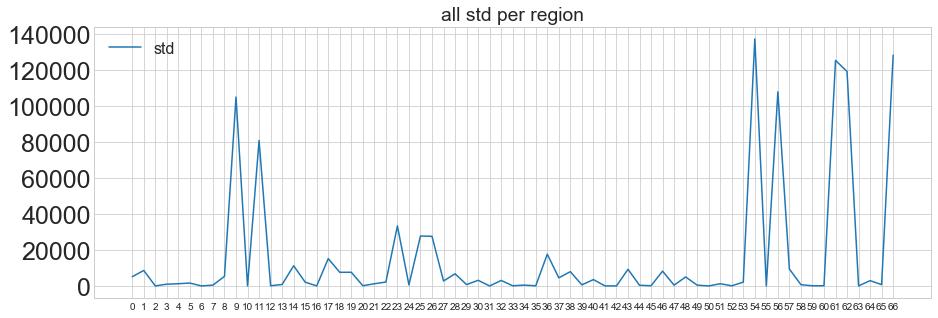

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
plt.rcParams.update({'font.size': 16})

plt.title( "all std per region"  )

#plt.plot(allVariancesPerRegion, label='var')
#plt.plot( allMeanTimerPerRegion, label='mean' )
plt.plot( allMeanTimerPerRegion, label='std' )

#ax.set_yscale('log', basey=10)
plt.xticks(np.arange( 0, numRegions, 1.0), fontsize=10)
plt.legend()

plt.show()

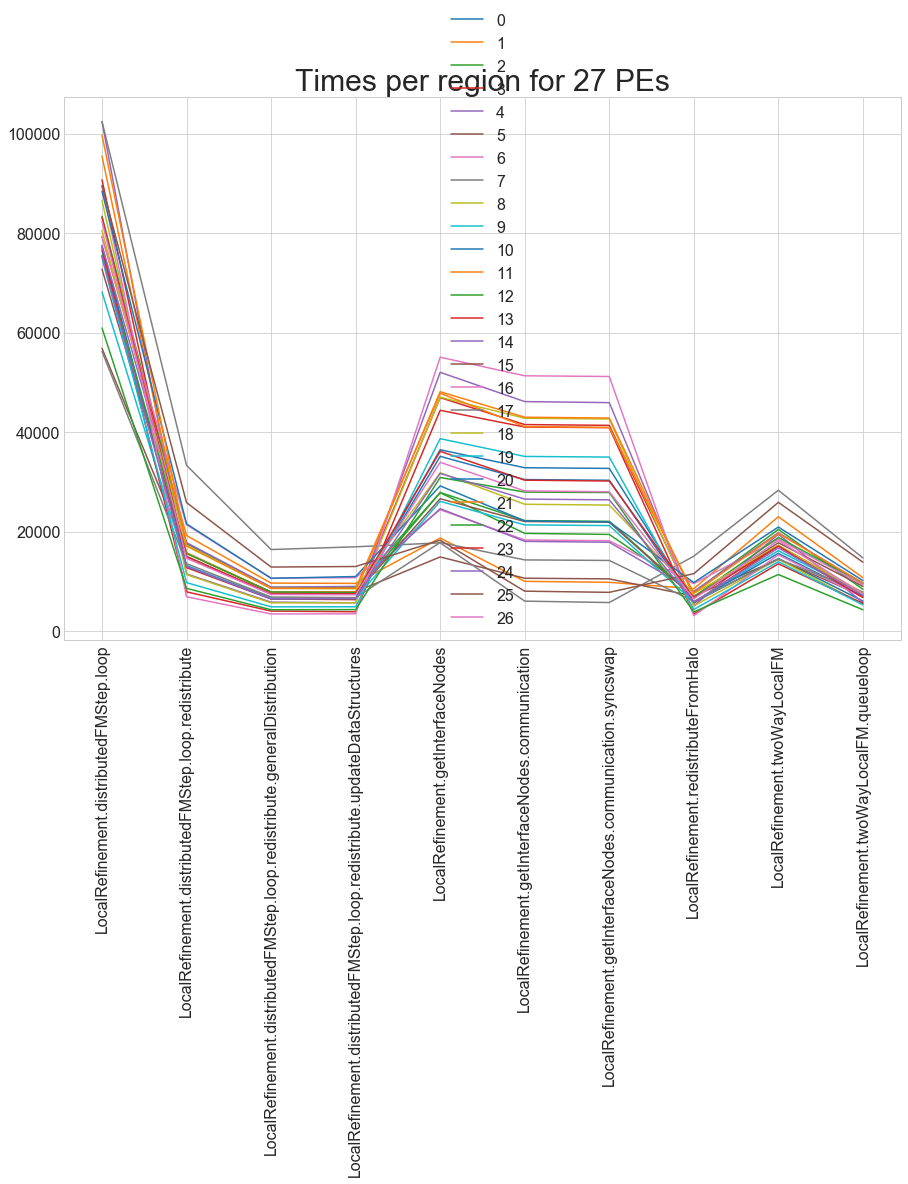

In [23]:
plotWantedPEsWantedRegions( allTimes, allPEs, wantedRegionNames,"region")

['GraphUtils.getNodesWithNonLocalNeighbors', 'GraphUtils.getNodesWithNonLocalNeighbors_cache', 'GraphUtils.getPEGraph', 'GraphUtils.getPEGraph.buildMatrix', 'GraphUtils.getPEGraph.getOwners', 'GraphUtils.nonLocalNeighbors']


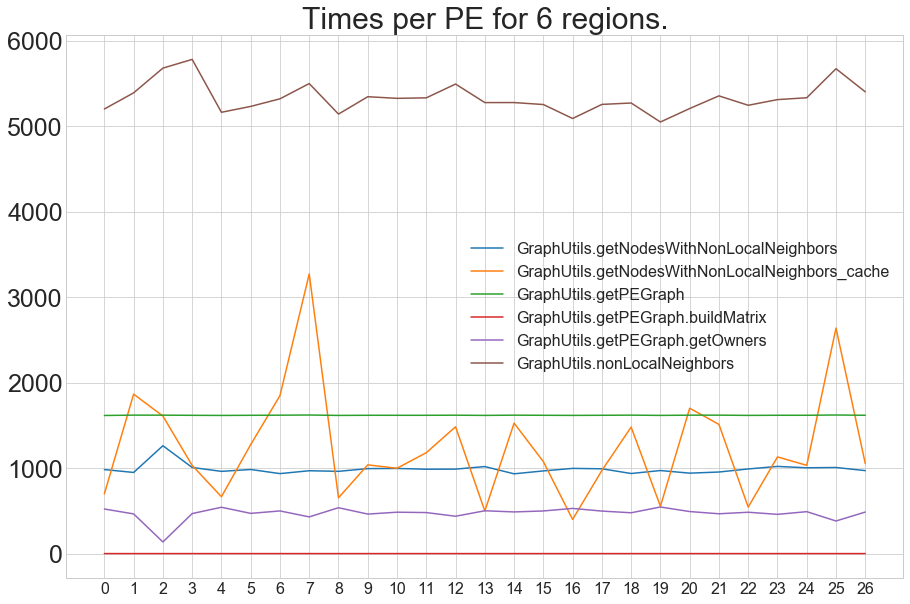

In [32]:
#wantedRegionNames= [regionNames[17], regionNames[8], regionNames[2], regionNames[19], regionNames[23], regionNames[31]]
#wantedRegionNames = regionNames[14:19]
wantedRegionNames = regionNames[3:9]
#wantedRegionNames.append( regionNames[53] )
print( wantedRegionNames )
plotWantedPEsWantedRegions( allTimes, allPEs, wantedRegionNames,"pe")

## Plot for wanted processor

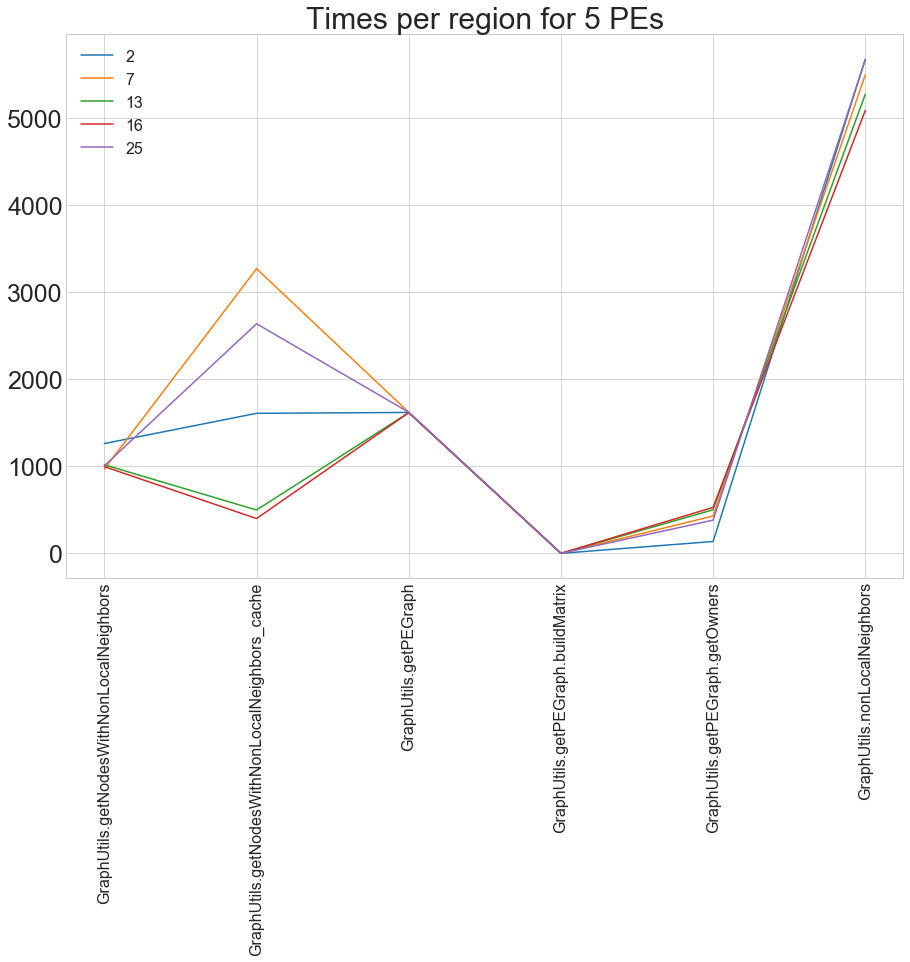

In [34]:
wantedPEs = [ 2, 7, 13, 16, 25]
plotWantedPEsWantedRegions( allTimes, wantedPEs, wantedRegionNames,"region")

In [ ]:
fig, ax = plt.subplots(figsize=(15,50))
plt.rcParams.update({'font.size': 25})

plt.title( "wantedPEs " +str(wantedPEs) )
plt.yticks( [j*(numWantedPES+1)+numWantedPES/2 for j in range(numRegions)], regionNames, rotation=0, fontsize=16 )

for i in range( numWantedPES ):
    assert( numRegions == len(allTimesForWantedPEs[i]) )
    
    yticksList = [j*(numWantedPES+1)+i for j in range(numRegions)]
    plt.barh( yticksList, allTimesForWantedPEs[i], label=wantedPEs[i] )

plt.legend()
plt.show

In [ ]:
def plotRawTimes( allTimes, wantedPEs, wantedRegions):
